# Relic Density Calculations

In [1]:
from hazma.scalar_mediator import ScalarMediator, HiggsPortal
from hazma.parameters import electron_mass as me
from hazma.parameters import muon_mass as mmu
from hazma.parameters import charged_pion_mass as mpi
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import vh, alpha_em, b0
from hazma.parameters import up_quark_mass as muq
from hazma.parameters import down_quark_mass as mdq

import numpy as np
from scipy.special import kn
from scipy.integrate import quad, solve_ivp
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt

In [2]:
mpl = 1.220910e19
sm_dof_data = np.genfromtxt('smdof.csv', skip_header=1, delimiter=',')
sm_temp_data, sm_gstar_data, sm_heff_data, sm_geff_data = sm_dof_data.T
sm_gstar_interp = UnivariateSpline(sm_temp_data, sm_gstar_data, ext=3)
sm_heff_interp = UnivariateSpline(sm_temp_data, sm_heff_data, ext=3)
sm_entropy_density = lambda T: 2.0 * np.pi**2 / 45.0 * sm_heff_interp(T) * T**3

In [60]:
mss = np.logspace(1.0, 3.0, num=20)
sthetas = np.logspace(-6, 0.0, num=20)
rds = np.zeros((len(mss), len(sthetas)), dtype=float)

In [96]:
hp = HiggsPortal(250.0, 1000.0, 1.0, 1.0)

In [97]:
hp.relic_density()

32.36516207383877

In [98]:
for i, ms in enumerate(mss):
    for j, stheta in enumerate(sthetas):
        hp = HiggsPortal(50.0, ms, 1.0, stheta)
        hp.ms = ms
        hp.stheta = stheta
        rds[i,j] = hp.relic_density()

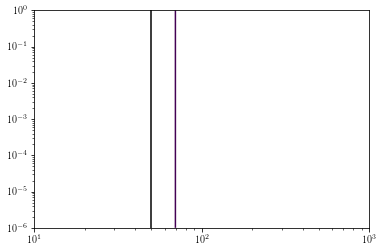

In [105]:
plt.contour(mss, sthetas, rds.T, [0.12])
plt.vlines(50.0, 1e-6, 1e0)
plt.yscale('log')
plt.xscale('log')

In [56]:
logxs, w = hp.solve_boltzmann()

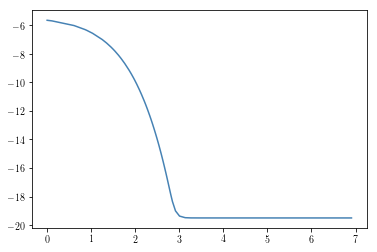

In [57]:
plt.plot(logxs, w[0])

In [2]:
sm = ScalarMediator(250.0, 100.0,1.0, 1.0,0.0, 0.0, 100e6)

In [7]:
boltzmann(np.log(400), np.array([-4.0]), sm)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:450: RuntimeWarning: divide by zero encountered in double_scalars
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:450: RuntimeWarning: invalid value encountered in double_scalars
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


array([-0.])

In [15]:
logxs, ys = sm.solve_boltzmann()

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:450: RuntimeWarning: divide by zero encountered in double_scalars
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:450: RuntimeWarning: invalid value encountered in double_scalars
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


In [16]:
kn(2, 500)**2

0.0

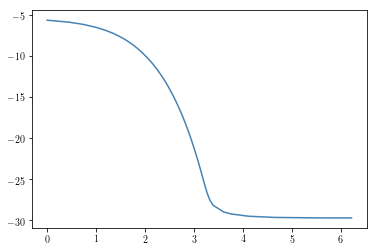

In [17]:
plt.plot(logxs, ys[0])

In [5]:
np.zeros((1,1))

array([[0.]])

## Scalar Mediator

### Thermal Cross Sections

In [113]:
def thermal_cs_xx_to_ss(sm, eps):

    # s = 4mx^2(1+eps). Check that Ecm = sqrt(s) > 2 ms
    if 4.0 * sm.mx**2 * (1 + eps) < 4 * sm.ms**2:
        return 0.0

    return (((sm.gsxx**4 *
              ((-2*np.sqrt((eps*(1 + eps - sm.ms**2/sm.mx**2)) /
                           (1 + eps)**2) *
                (3*sm.ms**4 - 16*sm.ms**2*sm.mx**2 +
                 8*(3 + eps)*sm.mx**4)) /
               (sm.ms**4 - 4*sm.ms**2*sm.mx**2 + 4*(1 + eps)*sm.mx**4) -
               ((3*sm.ms**4 - 8*(2 + eps)*sm.ms**2*sm.mx**2 + 8*(3 + eps*(6 + eps)) *
                 sm.mx**4) *
                np.log((sm.ms**2 + 2*(1 + eps) *
                        sm.mx*(-sm.mx +
                                 np.sqrt((eps*(-sm.ms**2 + (1 + eps)*sm.mx**2)) /
                                         (1 + eps)**2)))**2 /
                       (sm.ms**2 - 2*(1 + eps) *
                        sm.mx*(sm.mx + np.sqrt((eps*(-sm.ms**2 + (1 + eps)*sm.mx**2)) /
                                                   (1 + eps)**2)))**2)) /
               (-4*(1 + eps)*sm.ms**2*sm.mx**2 + 8*(1 + eps)**2*sm.mx**4))) /
             (64.*np.sqrt(eps)*np.sqrt(1 + eps)*sm.mx**2*np.pi)))

def thermal_cs_xx_to_pipi(sm, eps):
    # s = 4mx^2(1+eps). Check that Ecm = sqrt(s) > 2 ms
    if 4.0 * sm.mx**2 * (1 + eps) < 4 * mpi**2:
        return 0.0
    
    return ((np.sqrt(eps/(1 + eps))*
             sm.gsxx**2*np.sqrt((eps*(-mpi**2 + (1 + eps)*sm.mx**2))/
                                  ((1 + eps)**2*sm.mx**2))*
             (324*sm.gsGG*sm.lam**3*(mpi**2 - 2*(1 + eps)*sm.mx**2)*vh**2 + 
              b0*(mdq + muq)*(9*sm.lam + 4*sm.gsGG*sm.vs)*
              (-3*sm.lam*vh + 3*sm.gsff*sm.lam*sm.vs + 2*sm.gsGG*vh*sm.vs)*
              (2*sm.gsGG*vh*(9*sm.lam - 4*sm.gsGG*sm.vs) + 
               9*sm.gsff*sm.lam*(3*sm.lam + 4*sm.gsGG*sm.vs)))**2)/
            (52488.*sm.lam**6*np.pi*vh**4*(9*sm.lam + 4*sm.gsGG*sm.vs)**2*
             ((sm.ms**2 - 4*(1 + eps)*sm.mx**2)**2 + sm.ms**2*sm.width_s**2)))

def thermal_cs_xx_to_pi0pi0(sm, eps):
    # s = 4mx^2(1+eps). Check that Ecm = sqrt(s) > 2 mpi0
    if 4.0 * sm.mx**2 * (1 + eps) < 4 * mpi0**2:
        return 0.0

    return ((np.sqrt(eps/(1 + eps))*sm.gsxx**2 *
             np.sqrt((eps*(-mpi0**2 + (1 + eps)*sm.mx**2)) /
                     ((1 + eps)**2*sm.mx**2)) *
             (324*sm.gsGG*sm.lam**3*(mpi0**2 - 2*(1 + eps)*sm.mx**2)*vh**2 +
              b0*(mdq + muq)*(9*sm.lam + 4*sm.gsGG*sm.vs) *
              (-3*sm.lam*vh + 3*sm.gsff*sm.lam*sm.vs + 2*sm.gsGG*vh*sm.vs) *
              (2*sm.gsGG*vh*(9*sm.lam - 4*sm.gsGG*sm.vs) + 9*sm.gsff*sm.lam *
               (3*sm.lam + 4*sm.gsGG*sm.vs)))**2) /
            (104976.*sm.lam**6*np.pi*vh**4*(9*sm.lam + 4*sm.gsGG*sm.vs)**2 *
             ((sm.ms**2 - 4*(1 + eps)*sm.mx**2)**2 + sm.ms**2*sm.width_s**2)))

def thermal_cs_xx_to_mumu(sm, eps):
    # s = 4mx^2(1+eps). Check that Ecm = sqrt(s) > 2 mmu
    if 4.0 * sm.mx**2 * (1 + eps) < 4 * mmu**2:
        return 0.0

    gsll = sm.gsff * mmu / vh
    ml = mmu
    return ((eps*gsll**2*sm.gsxx**2*(-(ml**2/(1 + eps)) + sm.mx**2)**1.5) /
            (sm.mx*np.pi*((sm.ms**2 - 4*(1 + eps)*sm.mx**2)**2 + sm.ms**2*sm.width_s**2)))

def thermal_cs_xx_to_ee(sm, eps):
    # s = 4mx^2(1+eps). Check that Ecm = sqrt(s) > 2 me
    if 4.0 * sm.mx**2 * (1 + eps) < 4 * me**2:
        return 0.0

    gsll = sm.gsff * me / vh
    ml = me

    return ((eps*gsll**2*sm.gsxx**2*(-(ml**2/(1 + eps)) + sm.mx**2)**1.5) /
            (sm.mx*np.pi*((sm.ms**2 - 4*(1 + eps)*sm.mx**2)**2 + sm.ms**2*sm.width_s**2)))

def thermal_cs_xx_to_gg(sm, eps):


    return ((alpha_em**2*eps*(1 + eps)*sm.gsff**2*sm.gsxx**2*sm.mx**4) /
            (2.*sm.lam**2*np.pi**3*((sm.ms**2 - 4*(1 + eps)*sm.mx**2)**2 + sm.ms**2*sm.width_s**2)))

def integrand(sm, eps, x):
    pf = (2.0 * x / kn(2, x)**2 * np.sqrt(eps) * 
          (1 + 2 * eps) * kn(1, 2. * x * np.sqrt(1+eps)))
    tcs = (thermal_cs_xx_to_ss(sm, eps) + 
           thermal_cs_xx_to_pipi(sm, eps) +
           thermal_cs_xx_to_pi0pi0(sm, eps) + 
           thermal_cs_xx_to_mumu(sm, eps) + 
           thermal_cs_xx_to_ee(sm, eps) + 
           thermal_cs_xx_to_gg(sm, eps))
    
    return pf * tcs

def thermal_cs_tot(sm, x):
    def _integrand(eps):
        return integrand(sm, eps, x)
    return quad(_integrand, 0, np.inf, epsrel=1e-4, epsabs=1e-5)[0]

In [80]:
hp = HiggsPortal(250.0, 500.0, 1.0, 1e-6)

In [81]:
integrand(hp, 1.0, 1.0)

1.1378834312532694e-25

In [82]:
xs = np.logspace(0.0, 3.0, num=100)
tcs = np.array([thermal_cs_tot(hp, x) for x in xs])

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in double_scalars
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:100: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in double_scalars


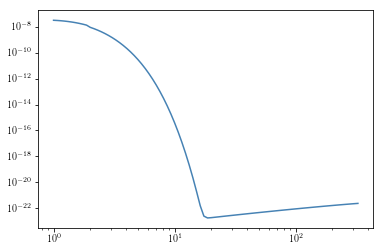

In [83]:
plt.plot(xs, tcs)
plt.yscale('log')
plt.xscale('log')

In [114]:
def boltzmann(logx, W, sm):
    x = np.exp(logx)
    T = sm.mx / x
    pf = (-np.sqrt(np.pi / 45.0) * mpl * T * sm_gstar_interp(T) * 
          thermal_cs_tot(sm, x))
    weq = np.log(45.0 / (4.0 * np.pi**4) * 2.0 / sm_heff_interp(T) * x**2 * kn(2, x))
    dW = np.zeros_like(W)
    dW[0] = pf * (np.exp(W[0]) - np.exp(2.0 * weq - W[0]))
    return dW

def jacobian(logx, W, sm):
    x = np.exp(logx)
    T = sm.mx / x
    pf = (-np.sqrt(np.pi / 45.0) * mpl * T * sm_gstar_interp(T) * 
          thermal_cs_tot(sm, x))
    weq = np.log(45.0 / (4.0 * np.pi**4) * 2.0 / sm_heff_interp(T) * x**2 * kn(2, x))
    
    J = np.zeros((1,1))
    J[0, 0] = pf * (np.exp(W[0]) - np.exp(2.0 * weq - W[0]))
    return J

In [115]:
hp = HiggsPortal(250.0, 100.0, 1.0, 1e-6)

In [128]:
for T, geff in zip(sm_temp_data, sm_geff_data):
    print("{}, {}".format(T, geff))

1.99526e-05, 3.38387
2.23872e-05, 3.38387
2.51189e-05, 3.38388
2.81838e-05, 3.38389
3.16228e-05, 3.38397
3.54814e-05, 3.38427
3.98107e-05, 3.38549
4.46684e-05, 3.3881
5.01187e-05, 3.39738
5.62341e-05, 3.41647
6.30958e-05, 3.45361
7.07946e-05, 3.51934
7.94328e-05, 3.62573
8.91251e-05, 3.78527
0.0001, 4.0102
0.000112202, 4.3118
0.000125892, 4.69996
0.000141254, 5.17649
0.000158489, 5.72974
0.000177828, 6.33782
0.000199526, 6.96665
0.000223872, 7.56535
0.000251189, 8.11056
0.000281838, 8.59272
0.000316228, 9.00495
0.000354813, 9.34736
0.000398107, 9.6294
0.000446684, 9.86545
0.000501187, 10.0587
0.000562341, 10.2142
0.000630957, 10.3381
0.000707946, 10.4387
0.000794328, 10.5198
0.000891251, 10.5838
0.001, 10.6332
0.00112202, 10.6713
0.00125892, 10.7017
0.00141254, 10.7286
0.00158489, 10.7517
0.00177828, 10.7704
0.00199526, 10.7844
0.00223872, 10.7937
0.00251189, 10.7998
0.00281838, 10.8043
0.00316228, 10.8083
0.00354813, 10.8132
0.00398107, 10.8184
0.00446684, 10.8231
0.00501187, 10.827
0

In [116]:
x0 = 1.0
T0 = hp.mx
w0 = np.array([np.log(45.0 / (4.0 * np.pi**4) * 2.0 /
                      sm_heff_interp(T0) * x0**2 * kn(2, x0))])

sol = solve_ivp(lambda t, Y: boltzmann(t, Y, hp),
                (np.log(x0), np.log(1000.0)),
                w0,
                method='Radau',
                jac=lambda t, Y: jacobian(t, Y, hp),
               rtol=1e-2, atol=1e-4)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


KeyboardInterrupt: 

## Vector Mediator